In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))
import time
import torch
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from CoExBO._utils import TensorManager
from CoExBO._coexbo import CoExBOwithSimulation, AlphaPIBOwithSimulation, CoTrustBOwithSimulation, StateManager


tm = TensorManager()
warnings.filterwarnings('ignore')

c:\Users\mauri\miniconda3\envs\ExplainableBO\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def BraninFunction(x):
    x = torch.atleast_2d(x)
    return ((x.sin() + (3*x).cos()/2).square() / ((x/2).square()+0.3)).prod(axis=1)

# Baseline: CoExBO

## 1. Problem definition
Let's get started with the toy example of two-dimensional Branin function.<br>
More details can be found [here](https://www.sfu.ca/~ssurjano/branin.html)<br>
- bounds: -2 from 3
- variable type: continuous
- ground truth X: [-1.02543108, -1.02543108]
- ground truth Y: 10.6043
- optimisation: maximisation

In [11]:
lower_limit = -2
upper_limit = 3
colour_map = 'summer'
resolution = 200
ground_truth = torch.tensor([-1.02543108, -1.02543108])

We assume we have a prior knowledge about this function.<br>
And we try to guide BO to rectify their recommendatation with help of explanation features.<br>
<br>
As we can see, the global maximum is at around [-1, -1].<br>
We can also observe there are 9 peaks for this function.<br>
We can expect BO can be stuck in one of these local maxima.<br>
<br>
Let's try to shepherd BO go to [-1, -1].

## 2. Define domain
Next, we define the domain of interest.
We set domain as uniform distribution bounded -2 from 3.

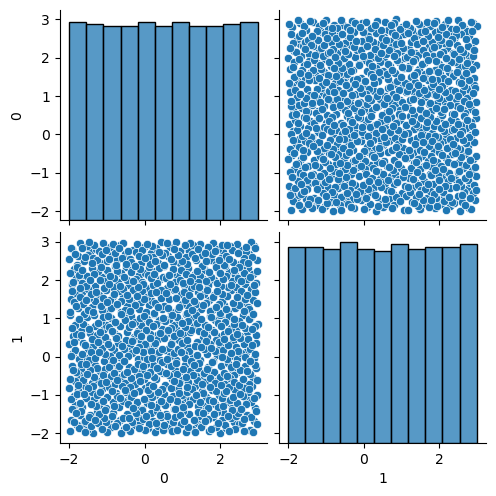

In [12]:


# set bounds
n_dims = 2                          # number of dimensions
mins = lower_limit * torch.ones(n_dims)
maxs = upper_limit * torch.ones(n_dims)
bounds = torch.vstack([mins, maxs]) # bounds

# set domain
from CoExBO._prior import Uniform    # Import prior from SOBER libraries
domain = Uniform(bounds)
true_function = BraninFunction

# visualise domain
samples = domain.sample(1000)
sns.pairplot(pd.DataFrame(tm.numpy(samples)))
plt.show()

## 3. Preferential learning
Next, we try to learn the prior knowledge of human user.<br>
For simplicity, human selection process is automatically generated with 60% accuracy via simulation.

In [13]:
n_init_pref = 100      # number of initial random samples for preferential learning
n_init_obj = 20        # number of initial random samples for objective function

coexbo = CoExBOwithSimulation(domain, true_function, sigma=0.1)
dataset_obj, dataset_duel = coexbo.initial_sampling(n_init_obj, n_init_pref)

## 4. Run CoExBO
Now, we will collaborate with BO for faster convergence.<br>

In [14]:
n_iterations = 10     # number of iterations
seed = 0              # random seed for reproduce the results

# initial setting
torch.manual_seed(seed)
state = StateManager(n_dims=n_dims)

In [15]:
results = []
for t in range(n_iterations):
    beta, gamma = state(t)
    result, dataset_obj, dataset_duel = coexbo(
        dataset_obj, dataset_duel, beta, gamma,
    )
    print(f"{len(dataset_obj[0])}) Best value: {dataset_obj[1].max().item():.5e}")
    results.append(result)


results = torch.tensor(results)

0) parameters: beta 5.657e-01 gamma 0.000e+00
21) Best value: 5.18014e+00
1) parameters: beta 8.000e-01 gamma 1.000e-02
22) Best value: 6.77953e+00
2) parameters: beta 9.798e-01 gamma 4.000e-02
23) Best value: 7.90578e+00
3) parameters: beta 1.131e+00 gamma 9.000e-02
24) Best value: 9.49497e+00
4) parameters: beta 1.265e+00 gamma 1.600e-01
25) Best value: 1.04118e+01
5) parameters: beta 1.386e+00 gamma 2.500e-01
26) Best value: 1.05914e+01
6) parameters: beta 1.497e+00 gamma 3.600e-01
27) Best value: 1.05929e+01
7) parameters: beta 1.600e+00 gamma 4.900e-01
28) Best value: 1.05958e+01
8) parameters: beta 1.697e+00 gamma 6.400e-01
29) Best value: 1.05963e+01
9) parameters: beta 1.789e+00 gamma 8.100e-01
30) Best value: 1.05976e+01


## Results
[overhead(s), best observation, Euclidean distance between the pairwise candidates, correct_answer_rate]

In [16]:
results

tensor([[3.4220e+00, 5.1801e+00, 1.3468e-03, 5.6931e-01],
        [2.0160e+00, 6.7795e+00, 3.8723e-02, 5.6863e-01],
        [2.1410e+00, 7.9058e+00, 1.6752e-03, 5.6311e-01],
        [2.7340e+00, 9.4950e+00, 1.7630e-03, 5.6731e-01],
        [2.6880e+00, 1.0412e+01, 8.2041e-03, 5.6190e-01],
        [2.0780e+00, 1.0591e+01, 3.6944e-04, 5.6604e-01],
        [2.0630e+00, 1.0593e+01, 3.8593e-04, 5.7009e-01],
        [2.2030e+00, 1.0596e+01, 2.7881e-04, 5.7407e-01],
        [2.1090e+00, 1.0596e+01, 2.5853e-04, 5.7798e-01],
        [2.4380e+00, 1.0598e+01, 1.7002e-04, 5.8182e-01]])

# Baseline: AlphaPiBO

In [9]:
lower_limit = -2
upper_limit = 3
colour_map = 'summer'
resolution = 200
ground_truth = torch.tensor([-1.02543108, -1.02543108])

In [10]:

# set bounds
n_dims = 2                          # number of dimensions
mins = lower_limit * torch.ones(n_dims)
maxs = upper_limit * torch.ones(n_dims)
bounds = torch.vstack([mins, maxs]) # bounds

# set domain
from CoExBO._prior import Uniform    # Import prior from SOBER libraries
domain = Uniform(bounds)
true_function = BraninFunction

# visualise domain
samples = domain.sample(1000)

In [11]:
n_init_pref = 100      # number of initial random samples for preferential learning
n_init_obj = 20        # number of initial random samples for objective function
alpha = 0.8
alphapibo = AlphaPIBOwithSimulation(domain, true_function, 
                                 sigma=alpha, uncertain_prior=True)
dataset_obj, dataset_duel = alphapibo.initial_sampling(n_init_obj, n_init_pref)

In [12]:
n_iterations = 10     # number of iterations
seed = 0              # random seed for reproduce the results
# initial setting
torch.manual_seed(seed)
state = StateManager(n_dims=n_dims, gamma_init=alpha, probabilistic_pi="alphapi")

In [7]:
results = []
for t in range(n_iterations):
    beta, gamma = state(t)
    result, dataset_obj, dataset_duel = alphapibo(
        dataset_obj, dataset_duel, beta, alpha,
    )
    print(f"{len(dataset_obj[0])}) Best value: {dataset_obj[1].max().item():.5e}")
    results.append(result)


results = torch.tensor(results)

0) parameters: beta 5.657e-01 gamma 8.000e-01
21) Best value: 3.22140e+00
1) parameters: beta 8.000e-01 gamma 8.000e-01
22) Best value: 4.70295e+00
2) parameters: beta 9.798e-01 gamma 8.000e-01
23) Best value: 4.73706e+00
3) parameters: beta 1.131e+00 gamma 8.000e-01
24) Best value: 4.95936e+00
4) parameters: beta 1.265e+00 gamma 8.000e-01
25) Best value: 5.02500e+00
5) parameters: beta 1.386e+00 gamma 8.000e-01
26) Best value: 5.03107e+00
6) parameters: beta 1.497e+00 gamma 8.000e-01
27) Best value: 5.03674e+00
7) parameters: beta 1.600e+00 gamma 8.000e-01
28) Best value: 5.03674e+00
8) parameters: beta 1.697e+00 gamma 8.000e-01
29) Best value: 5.03674e+00
9) parameters: beta 1.789e+00 gamma 8.000e-01
30) Best value: 5.03674e+00


## Results
[overhead(s), best observation, Euclidean distance between the pairwise candidates, correct_answer_rate]

In [8]:
results

tensor([[3.9060, 3.2214, 6.6697, 0.5644],
        [2.8590, 4.7029, 6.9335, 0.5637],
        [3.3130, 4.7371, 7.6328, 0.5631],
        [2.9060, 4.9594, 8.1263, 0.5625],
        [2.9530, 5.0250, 8.6934, 0.5619],
        [3.6720, 5.0311, 8.4558, 0.5613],
        [4.1410, 5.0367, 8.5139, 0.5607],
        [3.1090, 5.0367, 8.5365, 0.5648],
        [3.5160, 5.0367, 8.5984, 0.5642],
        [3.2500, 5.0367, 8.4522, 0.5636]])

# TrustCoBO

In [3]:
lower_limit = -2
upper_limit = 3
colour_map = 'summer'
resolution = 200
ground_truth = torch.tensor([-1.02543108, -1.02543108])

In [12]:

# set bounds
n_dims = 2                          # number of dimensions
mins = lower_limit * torch.ones(n_dims)
maxs = upper_limit * torch.ones(n_dims)
bounds = torch.vstack([mins, maxs]) # bounds

# set domain
from CoExBO._prior import Uniform    # Import prior from SOBER libraries
domain = Uniform(bounds)
true_function = BraninFunction

# visualise domain
samples = domain.sample(1000)

In [13]:
n_init_pref = 100      # number of initial random samples for preferential learning
n_init_obj = 20        # number of initial random samples for objective function
alpha = 0.9
trustbo = CoTrustBOwithSimulation(domain, true_function, sigma=0.1)
dataset_obj, dataset_duel = trustbo.initial_sampling(n_init_obj, n_init_pref)

In [14]:
n_iterations = 10     # number of iterations
seed = 0              # random seed for reproduce the results
# initial setting
torch.manual_seed(seed)
state = StateManager(n_dims=n_dims, gamma_init=alpha, probabilistic_pi="trustCo")

In [ ]:
torch.autograd.set_detect_anomaly(True)

results = []
for t in range(n_iterations):
    beta, alpha = state(t, trustbo)
    result, dataset_obj, dataset_duel = trustbo(
        dataset_obj, dataset_duel, beta, alpha,
    )
    print(f"{len(dataset_obj[0])}) Best value: {dataset_obj[1].max().item():.5e}")
    results.append(result)


results = torch.tensor(results)

0) parameters: beta 5.657e-01 gamma 9.000e-01


RuntimeError: 20 elements of the 20 element gradient array `gradf` are NaN. This often indicates numerical issues.

In [ ]:
results

tensor([[3.5470e+00, 4.7955e+00, 5.2046e-03, 5.6436e-01],
        [4.1880e+00, 5.7138e+00, 1.3045e-02, 5.5882e-01],
        [2.1560e+00, 6.9014e+00, 2.3380e-02, 5.5340e-01],
        [2.9380e+00, 8.5616e+00, 5.2575e-02, 5.4808e-01],
        [4.0780e+00, 9.8644e+00, 3.1720e-02, 5.4286e-01],
        [2.5000e+00, 1.0570e+01, 1.6100e-04, 5.4717e-01],
        [2.2340e+00, 1.0570e+01, 1.9477e-04, 5.5140e-01],
        [2.5470e+00, 1.0570e+01, 3.5468e-03, 5.5556e-01],
        [2.0470e+00, 1.0601e+01, 1.7970e-06, 5.5046e-01],
        [3.0320e+00, 1.0603e+01, 3.0685e-06, 5.5455e-01]])